Run the cell below to import amd and set options for printing results.

In [41]:
%pip install average-minimum-distance matplotlib

import amd
import numpy as np
import warnings

np.set_printoptions(precision=5, suppress=True)
warnings.filterwarnings("ignore", category=DeprecationWarning)

Note: you may need to restart the kernel to use updated packages.


## Example: dendrogram of CaCO3 polymorphs

In this example, we will read CaCO3.cif (<https://github.com/dwiddo/average-minimum-distance/tree/master/examples>) containing several forms of calcium carbonate from the Open Crystallography Database, create a distance matrix from their pointwise distance distributions, and plot a dendrogram seperating the polymorphs into groups. First, we'll find the distance between just two crystals:

In [42]:
crystals = list(amd.CifReader("CaCO3.cif")) # read crystals
pdds = [amd.PDD(crystal, 100) for crystal in crystals] # calculate PDDs (k=100)
d = amd.EMD(pdds[0], pdds[1]) # (Earth mover's) distance between 1st and 2nd PDDs
print(d)

0.09614150599999999


The above code reads crystals from a file, calculates their PDDs and finds the distance (Earth Mover's distance, EMD) bewteen the first two crystals. You may notice that the first time running the cell above is quite slow, but running the cell again is *significantly* faster. This is because the package relies on just-in-time compilation (numba) and the initial calls to ``amd.CifReader``, ``amd.PDD`` and ``amd.EMD`` spend most of the time in compilation, which is not repeated in subsequent calls.

With the PDDs and a function to calculate distances, we can now compute the distance matrix followed by the dendrogram. We will use ``hierarchy.linkage`` from ``scipy.cluster`` to compute the dendrogram, which expects a condensed distance matrix (explained [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy-spatial-distance-pdist)). The cell below does this manually for this demonstration, but the equivalent can be obtained with ``amd.PDD_pdist(pdds)``:

In [43]:
# equivalent to cdm = amd.PDD_pdist(pdds)
cdm = []
for i in range(len(pdds)):
    for j in range(i+1, len(pdds)):
        d = amd.EMD(pdds[i], pdds[j])
        cdm.append(d)
cdm = np.array(cdm)

Now a dendrogram can be plotted as follows:

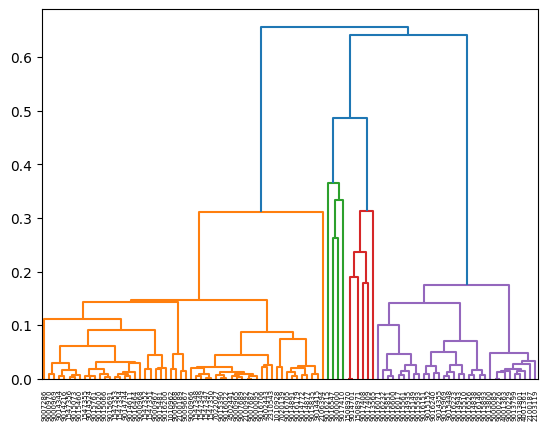

In [44]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

names = [crystal.name for crystal in crystals]
Z = hierarchy.linkage(cdm, "complete", optimal_ordering=True)
dn = hierarchy.dendrogram(Z, labels=names)
plt.show()

The resulting dendrogram shows 3 well-defined groups, the 3 polymorphs of CaCO3 (calcite, aragonite, vaterite). Changing k=100 in ``amd.PDD`` above to a smaller value like k=5 will show one large cluster, because these crystals consist of the same molecule whose atomic environments are not different for the first few neighbours of atoms. 

## Example: Fast comparisons with AMD

While PDDs are relatively fast to compare with earth mover's distance, collections of hundreds of thousands of crystals (for example, the entirety of the Open Crystallography Database) pose a computational challenge. Taking the average of a PDD gives the Average Minimum Distance (AMD), a vector with less information which still seperates structures well by geometry with significantly reduced cost of comparisons. The cell below plots the same dendrogram as the previous example, but with AMD instead of PDD:

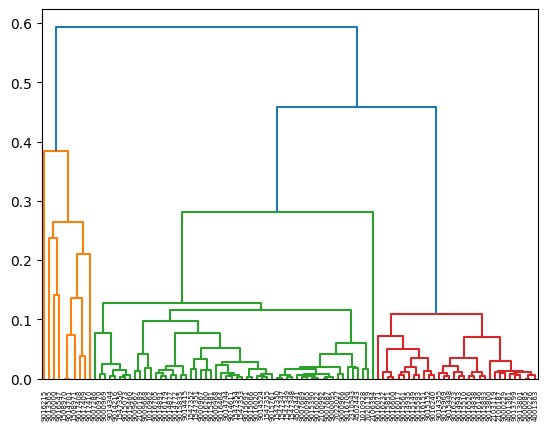

In [45]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

crystals = list(amd.CifReader("CaCO3.cif"))
amds = np.array([amd.AMD(crystal, 100) for crystal in crystals])
cdm = amd.AMD_pdist(amds)
names = [crystal.name for crystal in crystals]
Z = hierarchy.linkage(cdm, "complete", optimal_ordering=True)
dn = hierarchy.dendrogram(Z, labels=names)
plt.show()

To demonstrate the speed of AMD comparisons on many structures, we will generate many random structures and compare them. The cell below generates ``n_items`` random periodic sets, with 30 points randomly placed in a random unit cell with cell lengths betwee 1 and 2 and angles between 60 and 120 degrees. ``tqdm`` provides a progress bar for AMD calculation. Since AMDs are just vectors, 10,000 sets can be compared pairwise easily; increasing this parameter may eventually require you to use ``low_memory=True`` below.

In [46]:
from tqdm import tqdm

np.random.seed(1)
n_items = 10000
psets = [
    amd.PeriodicSet.random(n_points=30, length_bounds=(1.0, 2.0), angle_bounds=(60.0, 120.0))
    for _ in range(n_items)
]
amds = np.array([amd.AMD(pset, 100) for pset in tqdm(psets)])
cdm = amd.AMD_pdist(amds, low_memory=False)
print("smallest distance: ", np.amin(cdm))

100%|██████████| 10000/10000 [00:02<00:00, 4003.21it/s]


smallest distance:  0.006438721662578195


## Details of reading and comparison options

Several of the functions used in the previous examples have optional parameters allowing control over the reading or comparison of structures. Here we run through the CaCO3 dendrogram example, providing more details of usage and optional parameters (given their defaults below).

In [47]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

# CifReader is intended to be iterated over
reader = amd.CifReader(
    "CaCO3.cif", 
    reader="gemmi",           # gemmi or ccdc if csd-python-api installed
    remove_hydrogens=False,
    skip_disorder=False,      # skip over disordered structures
    heaviest_component=False, # remove lightest molecules (solvents)
    molecular_centres=False,  # take centres of moleucles as points
    show_warnings=True,
    verbose=False
)

# Does not keep items from CifReader in memory
names, pdds = [], []
for pset in reader:
    pdd = amd.PDD(
        pset,
        100,               # k = number of neighbours to consider for each atom
        lexsort=True,      # lexicographically sort rows
        collapse=True,     # collpase rows
        collapse_tol=1e-4, # tolerance for collapsing rows
        # Returns a tuple (pdd, row_data) with row_data detailing which PDD rows
        # correspond to which point in pset
        return_row_data=False
    )
    pdds.append(pdd)
    names.append(pset.name)

# Also accepts kwargs passed to scipy.cdist to compare PDD rows
cdm = amd.PDD_pdist(
    pdds,
    metric="chebyshev",        # metric to compare PDD rows
    backend="multiprocessing", # multiprocessing backend
    n_jobs=None,               # number of cores for multiprocessing
    verbose=False
)

print(cdm)

[0.09614 0.43137 0.44346 ... 0.17931 0.29227 0.2926 ]


## Details of PDD and EMD comparisons

In this example we will look at the contents of a PDD. A PDD matrix generally has one row for each point in an asymmetric unit, though rows are potentially collpased and a row could correspond to multiple points. The first element of a row is the 'weight' of the row, representing the frequency of this atomic environment amongst all those in the unit cell (equal to the Wyckoff multiplicity divided by the number of motif points). The rest of a row contains distances to the nearest neighbours of the atom, in order.

In [48]:
crystals = list(amd.CifReader("CaCO3.cif"))
crystal = crystals[0]
pdd, groups = amd.PDD(crystal, 5, return_row_data=True)

row = 2
print(f"PDD row {row}:")
print(f"    weight: {pdd[row, 0]}")
print(f"    first 5 neighbour distances: {pdd[row, 1:]}")
print(f"    index of row in asym unit: {groups[row]}")
# indices in groups point to .asym_unit, which in turn points to .motif
# since PDD rows collapse, a row can correspond to multiple points
motif_inds = crystal.asym_unit[groups[row]]
print(f"    asym unit point(s): {crystal.motif[motif_inds]}")
print(f"    atomic number(s): {crystal.types[groups[row]]}")
print(f"    label(s): {[crystal.labels[i] for i in groups[row]]}")
print(f"    multiplicitie(s): {crystal.multiplicities[groups[row]]}")

PDD row 2:
    weight: 0.2
    first 5 neighbour distances: [2.33781 2.33781 2.33781 2.33781 2.33781]
    index of row in asym unit: [0]
    asym unit point(s): [[3.79502 1.6148  1.04523]]
    atomic number(s): [20]
    label(s): ['Ca1']
    multiplicitie(s): [2]


When two PDDs are compared with earth mover's distance, their rows are matched with each other in a way that minimises the distance between matched rows while respecting the weights. Even if a crystal's symmetry is broken by a perturbation resulting in more PDD rows, the new rows now have smaller weights and correspond to old rows, giving a distance that changes smoothly under the perturbation. We can see which rows match with the optional ``return_transport`` parameter of EMD:

In [49]:
crystal1 = crystals[0]
crystal2 = crystals[1]

pdd1, groups1 = amd.PDD(crystal1, 100, return_row_data=True)
pdd2, groups2 = amd.PDD(crystal2, 100, return_row_data=True)
emd, transport = amd.EMD(pdd1, pdd2, return_transport=True)
print(transport)

[[0.2 0.  0. ]
 [0.  0.6 0. ]
 [0.  0.  0.2]]


The final EMD is a sum over the non-zero values of the matrix above, of the weight moved (the value in the ``transport`` array) multiplied by the distance between the relevant PDD rows. Let's print the details of the matching rows and the calculation giving the final EMD:

In [50]:
name1, name2 = crystal1.name, crystal2.name

weights_moved = []
for i, j in np.argwhere(transport > 1e-7):
    labs1 = ",".join([crystal1.labels[ind] for ind in groups1[i]])
    labs2 = ",".join([crystal2.labels[ind] for ind in groups2[j]])
    # Chebyshev metric between rows is the default
    row_dist = np.amax(np.abs(pdd1[i, 1:] - pdd2[j, 1:]))
    weight_moved = transport[i,j]
    print(
        f"{labs1} <-> {labs2}, weight={weight_moved:.3g}, row dist={row_dist:.4g}"
    )
    weights_moved.append((row_dist, transport[i,j]))

sum_str = " + ".join((f"{w:.3g}x{d:.4g}" for d, w in weights_moved))
emd_manual = sum(d * w for d, w in weights_moved)
print(f"Final EMD = {sum_str} = {emd_manual:.4g}")

C1 <-> C1, weight=0.2, row dist=0.06726
O1 <-> O1, weight=0.6, row dist=0.1165
Ca1 <-> Ca1, weight=0.2, row dist=0.06396
Final EMD = 0.2x0.06726 + 0.6x0.1165 + 0.2x0.06396 = 0.09614
